### GOING DEEPER:NLP 02

#### Table of Contents
1. Preprocessing
2. Sentencepiece Training
3. Sentencepiece 모델 비교
4. Sentencepiece를 통한 토크나이징을 NSMC 감정분석
5. Sentencepiece 성능비교
6. Konlpy Tokenize 연산속도 비교
7. Kobert, Khaiii 토큰화 방식 비교
8. Mecab을 활용한 NSMC Modeling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
pip install konlpy

In [ ]:
%%capture
pip install sentencepiece

In [ ]:
# Modules import
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import konlpy
import sentencepiece as spm
import os
import tensorflow as tf
import numpy as np
import time
import pandas as pd

%matplotlib inline

# 1. Preprocessing


In [ ]:
path_to_file = '/content/drive/MyDrive/naver_movie/ratings.txt'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 200001
Example:
>> id	document	label
>> 9468781	어?생각없이 봤는데 상당한 수작.일본영화 10년내 최고로 마음에 들었다.강렬한 임팩트가 일품.	1
>> 6809191	마치 바다속 , 아쿠아리움속으로 들어간듯한 느낌의 영화 어린자녀들에게 강추!!	1
>> 8255656	재밌습니다.재밌습니다.	1
>> 8499726	너무너무재밌게보고있어요! 중간부터 본방사수했지만 스토리가 탄탄하고 흥미진진해서 1화부터 다찾아서 봤네요 배우들 연기도 어디하나빠지는데가없네요 요새는 수백향만챙겨봐요	1


In [ ]:
data = pd.read_table(path_to_file)
data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
data.dropna(how='any', inplace=True)
data.drop_duplicates(inplace=True)

In [ ]:
print(f'remove null/duplicate data: {len(data)}')

remove null/duplicate data: 199992


In [ ]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

In [ ]:
check_sentence_with_length(raw, 11)

7477618	굿	1
5458245	핡	1
3946738	굿	1
7910238	휴	1
6924850	굿	1
7804013	ㅋ	1
5666738	ㅇ	1
3003689	굿	1
7830757	‥	1
6876426	O	1
773168	수작	1
3867260	굿	1
7250157	굿	1
7403577	갑	1
7505484	ㅎ	1
7483267	굿	1
7281794	.	1
117697	맞아	1
7225800	올	1
7721830	굿	1
7684134	헷	1
971290	명작	1
1426659	g	1
8012399	굿	1
261233	오우	1
7499560	♥	1
7764304	.	1
4483055	짱	1
4321484	짱	1
7317454	ㅆ	1
7863935	.	1
7723058	굿	1
7125585	짱	1
6813098	굿	1
7236009	.	1
4746939	굿	1
6297864	굿	1
7523848	굿	1
100226	gg	1
7083655	.	1
3891011	짱	1
7489303	굳	1
7436370	굿	1
5967897	잼	1
7903489	굿	1
3339077	짱	1
283968	후훗	1
3774728	굿	1
3382434	굿	1
7927389	ㅎ	1
6556188	굿	1
150372	나두	1
7677681	굿	1
1815836	굿	1
5277532	ㅁ	1
632718	^^	1
7264736	굳	1
6365131	굿	1
5978698	굿	1
6959675	?	1
7863562	ㅎ	1
3945553	굿	1
4319568	굿	1
7221937	.	1
7945393	짱	1
4493033	ㅇ	1
7330348	ㅋ	1
4016750	애	1
7143066	ㅋ	1
1447283	굿	1
7338439	?	1
79940	^-^	1
7284441	짱	1
7734153	.	1
7104728	흠	1
1403313	굿	1
7474858	ㅋ	1
7533249	찜	1
565434	조앙	1
453949	멋져	1
6898989	b	1
7516020	굿	1
6805929	굳	1
7172

In [ ]:
check_sentence_with_length(raw, 60)

7154137	순수함 그리고 진짜 웃음이 무엇인지 알 수 있었다그가 웃을때 나도 모르게 웃게 되는 순수함	1
7505364	10점도 안아까운 영화이다...블레이드러너에 버금가는 영화임 한국은 결코 만들수 없는...	1
7636847	상당히 현실성있고 중간중간 코믹요소도 좋았다. 리얼한 3류 양아치들의 애환을 잘 그려냈다.	1
4477460	완전 잼있네요 ㅋㅋ근데 이거 2편을 계획하고 끝낸거 같은데....2편은 어찌...?;;ㅜㅡ	1
9763750	현대소설속에서 많이 비쳐지던 죽음의 그림자가 짙게 드리워져 있는 여름향기가 못내 서글프네요	1
8559569	10점 아닌게 놀라울 따름!!주제가도 너무 좋아 벨소리로 쓴적도 있었다.The real!!	1
10275569	정말 미쓰와이프 별생각없이봤는데..왠걸요..너무재밌더라구요 ㅎ ㅎ돈이아깝지않은 영화입니다	1
7695857	3D 움직임이 허접해서 처음에 안볼라고 했는데, 색감도 너무 이쁘고 재밌음!!! 빠져들어~	1
9330402	진짜 호랑이다. 라이프오브파이 호랑이 본사람은 알것이다 cg기술이 뛰어나도 진짜는 못이긴다	1
7182947	최고! 시청률은 아마 편성문제인듯 다른드라마 하는 중간에 시작했으니 갈아타기 힘들었을거같다	1
7408190	예쁘고 강한 여주인공 캐릭터 별점 7개!, 스토리와 결말이 애매해서 별점 2개! 총 9개.	1
9340676	용감한 보카의 모험이야기~ 로봇이 약간 무섭게 느껴지지만 땅콩캐릭인가요?? 무지 귀엽네욘~	1
9180395	여자지만 홍영수 같은 대원 있으면 진심 짜증나고 난감할듯... 정철민 병장의 마음이 이해감	1
6490267	우연찮게 봤는데 재밌었어요(별점이해x) !!!ㅋㅋ 이영은씨 최성국씨 두분에 팬이되겠습니다!	1
10147557	이 영화 예전에는 8점대 후반이었는데 개베충의 엄청난 테러로 이만큼이나 평점이 떨어졌다.	1
7310072	여진구 완전 조으다, 목소리가 좋으니 당연, 더빙 연기도 좋구, 아이들도 늠늠 좋아했어요~	1
8573279	꿀잼 이예용 옥희의눈을통해 통

In [ ]:
document = data['document']

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


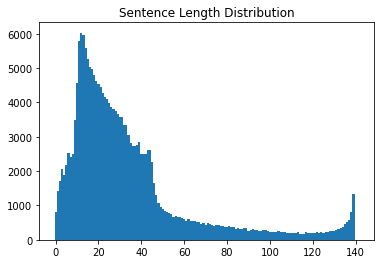

In [ ]:
min_len = 999
max_len = 0
sum_len = 0

for sen in document:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(document))

train_length = np.zeros((max_len), dtype=np.int)

for sen in document:   # 중복이 제거된 코퍼스 기준
    train_length[len(sen)-1] += 1

plt.bar(range(max_len), train_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
below_threshold_len(35, document)  # 평균
below_threshold_len(80, document)  
below_threshold_len(99, document) 

전체 샘플 중 길이가 35 이하인 샘플의 비율: 65.56262250490019
전체 샘플 중 길이가 80 이하인 샘플의 비율: 91.09164366574663
전체 샘플 중 길이가 99 이하인 샘플의 비율: 94.08976359054361


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


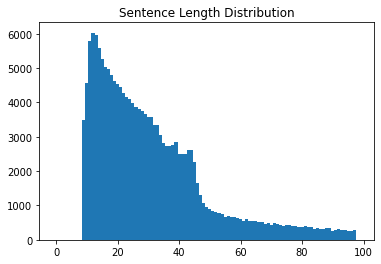

In [ ]:
max_len = 99
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = data[(data['document'].str.len() < max_len) & (data['document'].str.len() >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# 2. Sentencepiece Training

- nsmc_spm --> vocab_size = 8000, model_type= unigram
- nsmc_spm_2 --> vocab_size = 16000
- nsmc_spm_3 --> vocab_size = 16000, model_type=bpe

In [ ]:
import sentencepiece as spm
import pandas as pd

nsmc_file = '/content/drive/MyDrive/nsmc/ratings.txt'

vocab_size = 8000

with open(nsmc_file, 'w') as f:
    for row in filtered_corpus['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

#voacb_size=8000, model_type=unigram
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=nsmc_spm --vocab_size={}'.format(nsmc_file, vocab_size)    
)

#vocab_Size=16000
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=nsmc_spm_2 --vocab_size={}'.format(nsmc_file, vocab_size*2)    
)

#vocab_size=16000, model_type=bpe
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=nsmc_spm_3 --model_type=bpe --vocab_size={}'.format(nsmc_file, vocab_size*2)    
)

In [ ]:
!ls -l nsmc_spm*
!ls -l nsmc_spm_2*
!ls -l nsmc_spm_3*

-rw-r--r-- 1 root root 534974 Jul 11 06:24 nsmc_spm_2.model
-rw-r--r-- 1 root root 311695 Jul 11 06:24 nsmc_spm_2.vocab
-rw-r--r-- 1 root root 524176 Jul 11 06:24 nsmc_spm_3.model
-rw-r--r-- 1 root root 259406 Jul 11 06:24 nsmc_spm_3.vocab
-rw-r--r-- 1 root root 375232 Jul 11 06:23 nsmc_spm.model
-rw-r--r-- 1 root root 144694 Jul 11 06:23 nsmc_spm.vocab
-rw-r--r-- 1 root root 534974 Jul 11 06:24 nsmc_spm_2.model
-rw-r--r-- 1 root root 311695 Jul 11 06:24 nsmc_spm_2.vocab
-rw-r--r-- 1 root root 524176 Jul 11 06:24 nsmc_spm_3.model
-rw-r--r-- 1 root root 259406 Jul 11 06:24 nsmc_spm_3.vocab


### 우선적으로 nsmc_spm 기본모델 확인

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('nsmc_spm.model')

True

In [ ]:
import csv
vocab_list = pd.read_csv('nsmc_spm.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.sample(10)

,0,1
4279,▁남자의,-10.16830
4949,멋있,-10.33750
4819,▁아이들과,-10.30610
5747,갈때,-10.54640
5064,▁재밌었던,-10.37000
2659,ᄀ,-9.64308
6167,▁뻔뻔,-10.66230
3184,▁젊은,-9.82880
856,작품,-8.55119
6020,▁멋있고,-10.61930


### 단어집합의 크기 확인

In [ ]:
len(vocab_list)

8000

In [ ]:
s.GetPieceSize()

8000

### 서브워드로부터 맵핑되는 정수

In [ ]:
s.PieceToId('▁흥미로웠')

6240

### Sentecncepiece encode

In [ ]:
print(s.encode('흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', out_type=str))
print(s.encode('흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', out_type=int))

['▁흠', '...', '포스터', '보고', '▁초딩', '영화', '줄', '....', '오', '버', '연기', '조차', '▁가볍', '지', '▁않', '구나']
[1619, 8, 4539, 158, 1314, 32, 250, 50, 168, 467, 370, 1487, 4898, 19, 719, 485]


In [ ]:
with open('./nsmc_spm.vocab', encoding='utf-8') as f:
    Vo = [doc.strip().split("\t") for doc in f]

word2idx = {w[0]: i for i, w in enumerate(Vo)}

In [ ]:
word2idx

{'<unk>': 0,
 '<s>': 1,
 '</s>': 2,
 '▁': 3,
 '.': 4,
 '..': 5,
 '이': 6,
 '▁영화': 7,
 '...': 8,
 '가': 9,
 '의': 10,
 '도': 11,
 '는': 12,
 ',': 13,
 '을': 14,
 '에': 15,
 '고': 16,
 '다': 17,
 '은': 18,
 '지': 19,
 '?': 20,
 '한': 21,
 '▁너무': 22,
 '!': 23,
 '를': 24,
 '▁정말': 25,
 '만': 26,
 '▁이': 27,
 '로': 28,
 '▁진짜': 29,
 '나': 30,
 '게': 31,
 '영화': 32,
 '~': 33,
 '과': 34,
 '기': 35,
 '어': 36,
 '라': 37,
 '리': 38,
 '점': 39,
 '네': 40,
 '서': 41,
 '인': 42,
 '하고': 43,
 '아': 44,
 '▁안': 45,
 '으로': 46,
 '▁잘': 47,
 '!!': 48,
 '요': 49,
 '....': 50,
 '▁1': 51,
 '▁왜': 52,
 '에서': 53,
 '와': 54,
 '들': 55,
 '▁그': 56,
 '▁이런': 57,
 '▁아': 58,
 '▁더': 59,
 '▁다': 60,
 '해': 61,
 '▁수': 62,
 '네요': 63,
 '스': 64,
 '거': 65,
 '하는': 66,
 '자': 67,
 '▁그냥': 68,
 '▁본': 69,
 '▁드라마': 70,
 '음': 71,
 '면': 72,
 '▁10': 73,
 '수': 74,
 '하': 75,
 '시': 76,
 '지만': 77,
 '야': 78,
 '니': 79,
 '대': 80,
 '▁보고': 81,
 '함': 82,
 '▁평점': 83,
 '▁연기': 84,
 '사': 85,
 '▁내': 86,
 '▁한': 87,
 '하다': 88,
 '▁좀': 89,
 '일': 90,
 '하게': 91,
 '이다': 92,
 '▁영화를': 93,
 '▁봤

### tensor, word_index, index_word를 반환하는 sp_tokenize 정의

In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./nsmc_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [ ]:
lines = [
         "아 더빙.. 진짜 짜증나네요 목소리",
         "교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정"
]

tensor, word_index, index_word = sp_tokenize(s, lines)

for line in lines:
  print(line)
  print(tensor)
  print(word_index)
  print(index_word)
  print()

아 더빙.. 진짜 짜증나네요 목소리
[[   0    0    0    0    0    0    0   58  866    5   29 2015   63 1367]
 [1962   11  204  240 6560    3    5 5145 1167  117    5  668  293  129]]
{0: '<unk>', 1: '<s>', 2: '</s>', 3: '▁', 4: '.', 5: '..', 6: '이', 7: '▁영화', 8: '...', 9: '가', 10: '의', 11: '도', 12: '는', 13: ',', 14: '을', 15: '에', 16: '고', 17: '다', 18: '은', 19: '지', 20: '?', 21: '한', 22: '▁너무', 23: '!', 24: '를', 25: '▁정말', 26: '만', 27: '▁이', 28: '로', 29: '▁진짜', 30: '나', 31: '게', 32: '영화', 33: '~', 34: '과', 35: '기', 36: '어', 37: '라', 38: '리', 39: '점', 40: '네', 41: '서', 42: '인', 43: '하고', 44: '아', 45: '▁안', 46: '으로', 47: '▁잘', 48: '!!', 49: '요', 50: '....', 51: '▁1', 52: '▁왜', 53: '에서', 54: '와', 55: '들', 56: '▁그', 57: '▁이런', 58: '▁아', 59: '▁더', 60: '▁다', 61: '해', 62: '▁수', 63: '네요', 64: '스', 65: '거', 66: '하는', 67: '자', 68: '▁그냥', 69: '▁본', 70: '▁드라마', 71: '음', 72: '면', 73: '▁10', 74: '수', 75: '하', 76: '시', 77: '지만', 78: '야', 79: '니', 80: '대', 81: '▁보고', 82: '함', 83: '▁평점', 84: '▁연기', 85: '사', 86: '▁내', 8

### 3. Sentencepiece 모델 비교

#### 연산속도에 어떠한 차이가 있을까?

In [ ]:
text = """장해준 형사는 한국어를 쓰고, 그 로맨스 상대 송서래는 중국어를 쓴다. 서래의 한국말은 꽤 수준급이지만 그것을 원어로 쓰는 해준에 비해선 서툴다. 이런 서래를 배려해 해준은 어려운 단어를 ‘쉽게 풀어’ 설명해준다.
    언어가 다르지만 마음의 결은 같은 사람들끼리의 대화는 역시나 매력적이다. 한자로 축약된 단어를 ‘쉽게' 풀어 말할수록 오히려 더 원초적이고 솔직해진다. ‘외상성 두부 손상'은 ‘머리가 깨졌다'는 잔인한 말이 되고, ‘방수'는 ‘물을 막아 준다'는 단순한 뜻이 된다.
    이런 해준의 친절은 곧 서래에 대한 무의식적 호감이다. 상대를 배려하기 위해 애쓰는 사랑의 몸짓은 너무나 솔직하고 투명하다. 어려운 단어에 갸웃하는 서래와 그것을 설명해주는 해준 사이의 공기. 뜻을 이해하는 동안의 적막 속 말없이 서로를 응시했던 시간. 그것이 모여 두 사람의 감정이 쌓여 간다.
    영화의 대미인 ‘붕괴'라는 단어 또한 마찬가지다. “무너지고 깨어짐.” 두 사람의 관계, 혹은 해준의 일방적인 사랑이 얼마나 처참히 막을 내렸는지 알려주는 단어다. 그냥 ‘내가 붕괴됐어.’보단 ‘내가 무너지고 깨져 버렸어.’라는 말이 그 고통의 깊이를 더 절절히 담아낸다. 서래는 ‘붕괴'의 뜻을 사전에 찾아보고 나서야 해준이 자신을 얼마나 사랑했는지 알게 된다. 때문에 그녀에게 ‘붕괴'는 곧 ‘사랑'과 뜻을 같이한다.
    번역의 오차를 사용하는 것 또한 엄청난 쾌감을 준다. 중국어로 하는 서래의 혼잣말은 “그 친절한 형사의 ‘심장'을 가져다주세요.”였다. 하지만 번역기의 한계였을 뿐. 사실 그 말의 원래 뜻은 ‘심장'이 아니라 ‘마음’이었다. ‘심장'이란 오번역 덕분에 해준은 심장을 바칠 각오를 하고 그녀를 사랑한다. 이 관점에서 영화를 한 마디로 축약하자면 이렇게 말할 수도 있겠다.
  ‘심장까지 내어줄 각오를 했던 남자와 한 번도 가져보지 못한 마음이 필요했던 여자.’아무래도 탁월한 언어학자 한 분이 이 영화를 주제로 논문 한 편 써주시길 소망한다. 아주 멋진 글이 나올 거라 확신한다.
 """

In [ ]:
def test_tokenizer(sentencepiece_n):
  if sentencepiece_n == "nsmc_spm.model":
    s = spm.SentencePieceProcessor()
    s.Load('nsmc_spm.model')
    s.encode('text')
  elif sentencepiece_n == "nsmc_spm_2.model":
    s = spm.SentencePieceProcessor()
    s.Load('nsmc_spm_2.model')
    s.encode('text')
  else:
    s = spm.SentencePieceProcessor()
    s.Load('nsmc_spm_3.model')
    s.encode('text')
  
  return sentencepiece_n

In [ ]:
time_list = []
tokenizer_list = ["nsmc_spm.model", "nsmc_spm_2.model", "nsmc_spm_3.model"]

for i in tokenizer_list:
    start = time.time()
    test_tokenizer(i)    
    time_required = time.time() - start
    tokenizer_and_time = i, time_required
    
    time_list.append(tokenizer_and_time)

tokenizer_time = pd.DataFrame(time_list, columns = ['Tokenizer', 'Tokenizer_time'])

In [ ]:
tokenizer_time

,Tokenizer,Tokenizer_time
0,nsmc_spm.model,0.020905
1,nsmc_spm_2.model,0.039304
2,nsmc_spm_3.model,0.017693


- 사실 유의미한 차이라고 보기에는 어렵지만, vocab_size가 크고, bpe방식의 sentencepiece 모델이 연산속도가 빠른 것을 확인할 수 있음

### 4. Sentencepiece를 통한 토크나이징을 NSMC 감정분석
- vocab_size=16000, model_type= bpe 모델 사용

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('nsmc_spm_3.model')

True

In [ ]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus['document'])

In [ ]:
tensor

array([[    0,     0,     0, ...,  7623,   810,    12],
       [    0,     0,     0, ...,     3,    59, 14284],
       [    0,     0,     0, ...,  2058,    52,  6146],
       ...,
       [    0,     0,     0, ..., 14481,  1241, 14284],
       [    0,     0,     0, ...,  1438,  2432,    72],
       [    0,     0,     0, ..., 14539, 14289, 14539]], dtype=int32)

In [ ]:
from collections import Counter
from tensorflow import keras
from tensorflow.keras import Input, Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout

In [ ]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(filtered_corpus['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

### LSTM BASELINE MODEL 구축

In [ ]:
vocab_size = 16000
word_vector_dim = 64  

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5)

Epoch 1/5
3408/3408 [==============================] - 839s 245ms/step - loss: 0.3850 - acc: 0.8254 - val_loss: 0.3267 - val_acc: 0.8577
Epoch 2/5
3408/3408 [==============================] - 822s 241ms/step - loss: 0.2757 - acc: 0.8830 - val_loss: 0.3266 - val_acc: 0.8589
Epoch 3/5
3408/3408 [==============================] - 814s 239ms/step - loss: 0.2236 - acc: 0.9052 - val_loss: 0.3445 - val_acc: 0.8571
Epoch 4/5
3408/3408 [==============================] - 811s 238ms/step - loss: 0.1767 - acc: 0.9281 - val_loss: 0.3717 - val_acc: 0.8536
Epoch 5/5
3408/3408 [==============================] - 809s 237ms/step - loss: 0.1312 - acc: 0.9493 - val_loss: 0.4326 - val_acc: 0.8461


In [ ]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

852/852 - 15s - loss: 0.4241 - acc: 0.8458 - 15s/epoch - 17ms/step
[0.42411887645721436, 0.8457813858985901]


### 5. Sentencepiece 성능비교
#### - 위의 모델은 꽤나 성능이 준수하게 나옴을 확인. 그렇다면 vocab_size=8000, model_type=unigram인 sentencepiece는 어떨까?

In [ ]:
#model_type = unigram, vocab = 8000
l = spm.SentencePieceProcessor()
l.Load('nsmc_spm.model')
tensor, word_index, index_word = sp_tokenize(l, filtered_corpus['document'])

In [ ]:
from sklearn.model_selection import train_test_split
f
filtered_label = np.array(filtered_corpus['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [ ]:
vocab_size = 8000
word_vector_dim = 64  

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5)

Epoch 1/5
3408/3408 [==============================] - 820s 240ms/step - loss: 0.3878 - acc: 0.8226 - val_loss: 0.3330 - val_acc: 0.8528
Epoch 2/5
3408/3408 [==============================] - 825s 242ms/step - loss: 0.3001 - acc: 0.8702 - val_loss: 0.3265 - val_acc: 0.8598
Epoch 3/5
3408/3408 [==============================] - 817s 240ms/step - loss: 0.2630 - acc: 0.8880 - val_loss: 0.3207 - val_acc: 0.8607
Epoch 4/5
3408/3408 [==============================] - 815s 239ms/step - loss: 0.2283 - acc: 0.9043 - val_loss: 0.3414 - val_acc: 0.8564
Epoch 5/5
3408/3408 [==============================] - 816s 239ms/step - loss: 0.1947 - acc: 0.9197 - val_loss: 0.3746 - val_acc: 0.8548


In [ ]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

852/852 - 15s - loss: 0.3519 - acc: 0.8464 - 15s/epoch - 17ms/step
[0.35191911458969116, 0.8464049696922302]


### 마찬가지로 성능이 준수하기는 하나, 위의 토큰화 방식이 더 잘 작동함을 확인

# 6. Konlpy Tokenize 연산속도 비교

In [ ]:
#Mecab 설치
%%capture
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
import konlpy
import konlpy.tag

In [ ]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

In [ ]:
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    elif tokenizer_name == "kkma":
        tokenizer = Kkma()
    else:
        tokenizer = Mecab()
    return tokenizer

In [ ]:
# 위와 동일한 텍스트로 연산속도비교!
text = """장해준 형사는 한국어를 쓰고, 그 로맨스 상대 송서래는 중국어를 쓴다. 서래의 한국말은 꽤 수준급이지만 그것을 원어로 쓰는 해준에 비해선 서툴다. 이런 서래를 배려해 해준은 어려운 단어를 ‘쉽게 풀어’ 설명해준다.
    언어가 다르지만 마음의 결은 같은 사람들끼리의 대화는 역시나 매력적이다. 한자로 축약된 단어를 ‘쉽게' 풀어 말할수록 오히려 더 원초적이고 솔직해진다. ‘외상성 두부 손상'은 ‘머리가 깨졌다'는 잔인한 말이 되고, ‘방수'는 ‘물을 막아 준다'는 단순한 뜻이 된다.
    이런 해준의 친절은 곧 서래에 대한 무의식적 호감이다. 상대를 배려하기 위해 애쓰는 사랑의 몸짓은 너무나 솔직하고 투명하다. 어려운 단어에 갸웃하는 서래와 그것을 설명해주는 해준 사이의 공기. 뜻을 이해하는 동안의 적막 속 말없이 서로를 응시했던 시간. 그것이 모여 두 사람의 감정이 쌓여 간다.
    영화의 대미인 ‘붕괴'라는 단어 또한 마찬가지다. “무너지고 깨어짐.” 두 사람의 관계, 혹은 해준의 일방적인 사랑이 얼마나 처참히 막을 내렸는지 알려주는 단어다. 그냥 ‘내가 붕괴됐어.’보단 ‘내가 무너지고 깨져 버렸어.’라는 말이 그 고통의 깊이를 더 절절히 담아낸다. 서래는 ‘붕괴'의 뜻을 사전에 찾아보고 나서야 해준이 자신을 얼마나 사랑했는지 알게 된다. 때문에 그녀에게 ‘붕괴'는 곧 ‘사랑'과 뜻을 같이한다.
    번역의 오차를 사용하는 것 또한 엄청난 쾌감을 준다. 중국어로 하는 서래의 혼잣말은 “그 친절한 형사의 ‘심장'을 가져다주세요.”였다. 하지만 번역기의 한계였을 뿐. 사실 그 말의 원래 뜻은 ‘심장'이 아니라 ‘마음’이었다. ‘심장'이란 오번역 덕분에 해준은 심장을 바칠 각오를 하고 그녀를 사랑한다. 이 관점에서 영화를 한 마디로 축약하자면 이렇게 말할 수도 있겠다.
  ‘심장까지 내어줄 각오를 했던 남자와 한 번도 가져보지 못한 마음이 필요했던 여자.’아무래도 탁월한 언어학자 한 분이 이 영화를 주제로 논문 한 편 써주시길 소망한다. 아주 멋진 글이 나올 거라 확신한다.
 """

In [ ]:
import time
import pandas as pd

time_list = []
tokenizer_list = ["komoran", "okt", "mecab", "hannanum", "kkma"]

for i in tokenizer_list:
    start = time.time()
    tokenizer = get_tokenizer(i)
    tokenizer.morphs(text)
    
    time_required = time.time() - start
    tokenizer_and_time = i, time_required
    
    time_list.append(tokenizer_and_time)

Konlpy_Tokenizer_time = pd.DataFrame(time_list, columns = ['Tokenizer', 'Tokenizer_time'])


In [ ]:
Konlpy_Tokenizer_time

,Tokenizer,Tokenizer_time
0,komoran,2.006054
1,okt,0.012535
2,mecab,0.001498
3,hannanum,0.532593
4,kkma,0.105328


- 여기서는 토큰화 연산속도가 비교적 크게 드러난다! 

In [ ]:
tokenized_list = []

for  i in tokenizer_list:
  tokenizer = get_tokenizer(i)
  tokenized = tokenizer.morphs('사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다')
  tokenized_list.append(tokenized)

Konlpy_tokenized = pd.DataFrame({'tokneized_list':tokenized_list}, index=tokenizer_list)
Konlpy_tokenized

,tokneized_list
komoran,"[사이몬페그의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 던, 영화, !, 스..."
okt,"[사이, 몬페, 그, 의, 익살스런, 연기, 가, 돋보였던, 영화, !, 스파이더맨..."
mecab,"[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보였, 던, 영화, !, 스파이더맨..."
hannanum,"[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보이, 었던, 영화, !, 스파이더..."
kkma,"[사이몬페그, 의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 더, ㄴ, 영화,..."


In [ ]:
from google.colab import data_table
data_table.DataTable(Konlpy_tokenized, include_index=True,  num_rows_per_page=10)

,tokneized_list
komoran,"[사이몬페그의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 던, 영화, !, 스..."
okt,"[사이, 몬페, 그, 의, 익살스런, 연기, 가, 돋보였던, 영화, !, 스파이더맨..."
mecab,"[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보였, 던, 영화, !, 스파이더맨..."
hannanum,"[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보이, 었던, 영화, !, 스파이더..."
kkma,"[사이몬페그, 의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 더, ㄴ, 영화,..."


#### 연산 속도로 보았을 때 kkma가 가장 느리고, mecab이 연산속도가 가장 빠른 것을 확인할 수 있다. 
#### komoran, okt의 경우 '사이몬페그'라는 고유명사를 제대로 토크나이징 못하고 있다!

<hr>

# 7. Kobert, Khaiii 토큰화 방식 비교
## KONLPY에 있는거 봤으니까... 다른 Tokenizer들은 어떨까?



### Kobert

In [ ]:
%%capture
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [ ]:
import torch
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
import gluonnlp as nlp

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model(cachedir = ".cache")
tokenizer = get_tokenizer()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

In [ ]:
text = '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다'

In [ ]:
tok(text)

['▁사이',
 '몬',
 '페',
 '그',
 '의',
 '▁익',
 '살',
 '스',
 '런',
 '▁연기',
 '가',
 '▁',
 '돋',
 '보',
 '였던',
 '▁영화',
 '▁',
 '!',
 '▁스',
 '파',
 '이',
 '더',
 '맨',
 '에서',
 '▁',
 '늙',
 '어',
 '보이',
 '기',
 '만',
 '▁했던',
 '▁커',
 '스',
 '틴',
 '▁',
 '던',
 '스트',
 '가',
 '▁너무',
 '나',
 '도',
 '▁이',
 '뻐',
 '보',
 '였다']

### 카카오 khaiii Tokenizer

In [ ]:
%%capture
!git clone https://github.com/kakao/khaiii.git

In [ ]:
%%capture
!pip install cmake

In [ ]:
!mkdir build

mkdir: cannot create directory ‘build’: File exists


In [ ]:
%%capture
!cd build && cmake /content/khaiii

In [ ]:
%%capture
!cd /content/build/ && make all

In [ ]:
%%capture
!cd /content/build/ && make resource

In [ ]:
%%capture
!cd /content/build && make install

In [ ]:
%%capture
!cd /content/build && make package_python

In [ ]:
%%capture
!pip install /content/build/package_python

In [ ]:
from khaiii import KhaiiiApi
tokenizer = KhaiiiApi()

data = tokenizer.analyze(text)

tokens = []

for word in data:
    tokens.extend([str(m).split('/')[0] for m in word.morphs])

tokens

['사',
 '이몬페그',
 '의',
 '익살',
 '스럽',
 'ㄴ',
 '연기',
 '가',
 '돋보이',
 '었',
 '던',
 '영화',
 '!',
 '스파',
 '이',
 '더맨',
 '에서',
 '늙',
 '어',
 '보',
 '이',
 '기',
 '만',
 '하',
 '였',
 '던',
 '커스틴',
 '던',
 '스트',
 '가',
 '너무나',
 '도',
 '이쁘',
 '어',
 '보이',
 '었',
 '다']

# 8. Mecab을 활용한 NSMC Modeling

In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()

filtered_corpus['tokenized'] = filtered_corpus['document'].apply(tokenizer.morphs)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_corpus['tokenized'])

In [ ]:
tensor = tokenizer.texts_to_sequences(filtered_corpus['tokenized'])
tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

In [ ]:
tensor

array([[    0,     0,     0, ...,    37,    70,    49],
       [    0,     0,     0, ...,     1,    57,     1],
       [    0,     0,     0, ...,    42,     4,    21],
       ...,
       [    0,     0,     0, ..., 22373,     5,     1],
       [    0,     0,     0, ...,   495,  1149,    49],
       [    0,     0,     0, ...,  6007, 53628, 53629]], dtype=int32)

In [ ]:
filtered_label = np.array(filtered_corpus['label'])

x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

### 동일하게 LSTM BASELINE MODEL 사용

In [ ]:
vocab_size = 16000
word_vector_dim = 64

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5)

Epoch 1/5
3408/3408 [==============================] - 800s 234ms/step - loss: 0.3754 - acc: 0.8318 - val_loss: 0.3314 - val_acc: 0.8556
Epoch 2/5
3408/3408 [==============================] - 792s 232ms/step - loss: 0.2852 - acc: 0.8802 - val_loss: 0.3189 - val_acc: 0.8632
Epoch 3/5
3408/3408 [==============================] - 791s 232ms/step - loss: 0.2392 - acc: 0.9015 - val_loss: 0.3285 - val_acc: 0.8652
Epoch 4/5
3408/3408 [==============================] - 789s 231ms/step - loss: 0.2012 - acc: 0.9197 - val_loss: 0.3587 - val_acc: 0.8630
Epoch 5/5
3408/3408 [==============================] - 790s 232ms/step - loss: 0.1671 - acc: 0.9353 - val_loss: 0.3959 - val_acc: 0.8576


In [ ]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

852/852 - 14s - loss: 0.3961 - acc: 0.8579 - 14s/epoch - 17ms/step
[0.39610353112220764, 0.8578503131866455]


### 회고

1. 어절? 형태소? Subword? 여기서 어떠한 방법론을 택할 것이냐?

2. tokenizer를 사용한다는 것. 어절 단위로 한다는 것은 공백을 기준으로 토큰화한다는 것이고, 이는 한국어와 같은 교착어에서는 적합한 방법론이 아니다. 그렇다면 조금 더 쪼개어서 '형태소' 단위의 토큰을 구사할 수도 있고, 혹은 노드에서 제시한 방법대로 BPE와 같은 형태의 subword tokenize를 선택할 수 있다.

3. 여기서 Subword 단위 tokenize에 이러한 문제가 등장할 수 있다. "oov를 어떻게 해결할 것이냐?"

4. 문서 군집화/분류/기계번역 등의 분야에서는 subwords 기반으로 단어를 표현함으로써 미등록 단어 문제를 우회할 수 있다!

5. 반면 키워드/연관어 분석, 토필 모델링과 같은 분석을 위해서는 온전한 단어로 인식해야하기에 subwords를 활용할 수 없다. 따라서 해당 tokenizer를 단순히 연산성능평가와 같은 척도로만 평가되어질 수 없으며, 해결하고자하는 task가 무엇인지에 따라 달라질 수 있다. 

6. 기존의 Tokenizer들의 연산속도, 토큰화 처리방식이 어떠한지를 살펴보는 작업이 첫째로 이루어져야하며, 풀고자하는 과제가 무엇인가에 따라 어떠한 토큰화방식을 택할 것인지 선택할 수 있다.
